In [1]:
import torch
from transformer_lens import HookedTransformer
import numpy as np 
from torch import nn
import pickle

# Define the autoencoder so pickle knows how to serialize it. 
# Later, we should actually save as a state_dict instead of a dumb pickle
class AutoEncoder(nn.Module):
    def __init__(self, activation_size, n_dict_components, t_type=torch.float32, l1_coef=0.0):
        super(AutoEncoder, self).__init__()
        
        # Only defining the decoder layer, encoder will share its weights
        self.decoder = nn.Linear(n_dict_components, activation_size, bias=True)
        # Create a bias layer
        self.encoder_bias= nn.Parameter(torch.zeros(n_dict_components))

        
        # Initialize the decoder weights orthogonally
        nn.init.orthogonal_(self.decoder.weight)
        self.decoder = self.decoder.to(t_type)

        # Encoder is a Sequential with the ReLU activation
        # No need to define a Linear layer for the encoder as its weights are tied with the decoder
        self.encoder = nn.Sequential(nn.ReLU()).to(t_type)

        self.l1_coef = l1_coef
        self.activation_size = activation_size
        self.n_dict_components = n_dict_components

    def forward(self, x):
        c = self.encoder(x @ self.decoder.weight + self.encoder_bias)
        # Apply unit norm constraint to the decoder weights
        self.decoder.weight.data = nn.functional.normalize(self.decoder.weight.data, dim=0)

        # Decoding step as before
        x_hat = self.decoder(c)
        return x_hat, c


    @property
    def device(self):
        return next(self.parameters()).device

/home/mchorse/miniconda3/envs/logan/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Load Dictionaries

In [204]:
#Change these settings to load the correct autoencoder
# filename = "/home/mchorse/logan_sparse_coding/sparse_coding/layer-2-autoencoder.pkl"
# filename = "outputs/20230720-192301-EleutherAI/pythia-70m-deduped-2/minirun9/autoencoders.pkl"
# filename = "outputs/20230720-192301-EleutherAI/pythia-70m-deduped-2/minirun5/autoencoders.pkl"
# filename = "outputs/20230721-161919-EleutherAI/pythia-70m-deduped-2/minirun9/autoencoders.pkl"
# filename = "outputs/20230721-161919-EleutherAI/pythia-70m-deduped-2/minirun3/autoencoders.pkl"
filename = "outputs/20230804-205842-EleutherAI/pythia-70m-deduped-2/minirun4/autoencoders.pkl"
layer = 2
setting = "residual"
model_name = "EleutherAI/pythia-70m-deduped"

device = torch.device("cuda:5" if torch.cuda.is_available() else "cpu")
model = HookedTransformer.from_pretrained(model_name, device=device)

if setting == "residual":
    cache_name = f"blocks.{layer}.hook_resid_post"
    neurons = model.cfg.d_model
elif setting == "mlp":
    cache_name = f"blocks.{layer}.mlp.hook_post"
    neurons = model.cfg.d_mlp
else:
    raise NotImplementedError


# Load the pickle file
with open(filename, 'rb') as file:
    autoencoders = pickle.load(file)

# Index for l1 value, usually only 1 value is available
l1_index = 1
dictionaries = [autoencoder.decoder.weight.data.T for autoencoder in autoencoders[l1_index]]
for d in dictionaries:
    print(d.shape)
print("len of autoencoders: ", len(autoencoders))
dict_index = 1
smaller_dict, larger_dict = dictionaries[dict_index], dictionaries[dict_index+1]
smaller_auto_encoder, larger_auto_encoder = autoencoders[l1_index][dict_index], autoencoders[l1_index][dict_index+1]

Using pad_token, but it is not set yet.


Loaded pretrained model EleutherAI/pythia-70m-deduped into HookedTransformer
torch.Size([4096, 512])
len of autoencoders:  9


IndexError: list index out of range

In [185]:
#Change these settings to load the correct autoencoder
# filename = "/home/mchorse/logan_sparse_coding/sparse_coding/layer-2-autoencoder.pkl"
filename = "outputs/20230720-192301-EleutherAI/pythia-70m-deduped-2/minirun9/autoencoders.pkl"
# filename = "outputs/20230720-192301-EleutherAI/pythia-70m-deduped-2/minirun5/autoencoders.pkl"
filename2 = "outputs/20230721-161919-EleutherAI/pythia-70m-deduped-2/minirun9/autoencoders.pkl"
# filename = "outputs/20230721-161919-EleutherAI/pythia-70m-deduped-2/minirun3/autoencoders.pkl"
layer = 2
setting = "residual"
model_name = "EleutherAI/pythia-70m-deduped"

device = torch.device("cuda:4" if torch.cuda.is_available() else "cpu")
model = HookedTransformer.from_pretrained(model_name, device=device)

if setting == "residual":
    cache_name = f"blocks.{layer}.hook_resid_post"
    neurons = model.cfg.d_model
elif setting == "mlp":
    cache_name = f"blocks.{layer}.mlp.hook_post"
    neurons = model.cfg.d_mlp
else:
    raise NotImplementedError


# Load the pickle file
with open(filename, 'rb') as file:
    autoencoders = pickle.load(file)

# Load the pickle file
with open(filename2, 'rb') as file:
    autoencoders2 = pickle.load(file)

# Index for l1 value, usually only 1 value is available
l1_index = 1
dictionaries = [autoencoder.decoder.weight.data.T for autoencoder in autoencoders[l1_index]]
dictionaries2 = [autoencoder.decoder.weight.data.T for autoencoder in autoencoders2[l1_index]]
for d in dictionaries:
    print(d.shape)
print("len of autoencoders: ", len(autoencoders))
dict_index = 1
smaller_dict, larger_dict = dictionaries[dict_index], dictionaries2[dict_index]
smaller_auto_encoder, larger_auto_encoder = autoencoders[l1_index][dict_index], autoencoders2[l1_index][dict_index]

Using pad_token, but it is not set yet.


Loaded pretrained model EleutherAI/pythia-70m-deduped into HookedTransformer
torch.Size([2048, 512])
torch.Size([4096, 512])
torch.Size([8192, 512])
len of autoencoders:  3


In [216]:
from scipy.optimize import linear_sum_assignment
# DO THE MCS across all dictionaries
def mcs(dict1, dict2):
    dict1_features, _ = dict1.shape
    dict2_features, _ = dict2.shape
    dict2 = dict2.to(device)
    # Hungary algorithm
    # Calculate all cosine similarities and store in a 2D array
    cos_sims = np.zeros((dict1_features, dict2_features))
    for idx, vector in enumerate(dict1):
        cos_sims[idx] = torch.nn.functional.cosine_similarity(vector.to(device), dict2, dim=1).cpu().numpy()
    # Convert to a minimization problem
    cos_sims = 1 - cos_sims
    # Use the Hungarian algorithm to solve the assignment problem
    row_ind, col_ind = linear_sum_assignment(cos_sims)
    # Retrieve the max cosine similarities and corresponding indices
    max_cosine_similarities = 1 - cos_sims[row_ind, col_ind]
    max_indices = np.argsort(max_cosine_similarities)[::-1].copy()
    return max_cosine_similarities, max_indices


l1_index = 0
# dictionaries = [autoencoder.decoder.weight.data.T for autoencoder in autoencoders[l1_index]]
# dictionaries2 = [autoencoder.decoder.weight.data.T for autoencoder in autoencoders2[l1_index]]
dictionaries = [autoencoder[0].decoder.weight.data.T for autoencoder in autoencoders]
# combined_dicts = dictionaries + dictionaries2
combined_dicts = dictionaries
adjancy_matrix = np.zeros((len(combined_dicts), len(combined_dicts)))
for i in range(len(combined_dicts)):
    for j in range(len(combined_dicts)):
        if j > i:
            break
        max_cosine_similarities, max_indices = mcs(combined_dicts[i], combined_dicts[j])
        adjancy_matrix[i, j] = max_cosine_similarities.mean()
        adjancy_matrix[j, i] = max_cosine_similarities.mean()

9


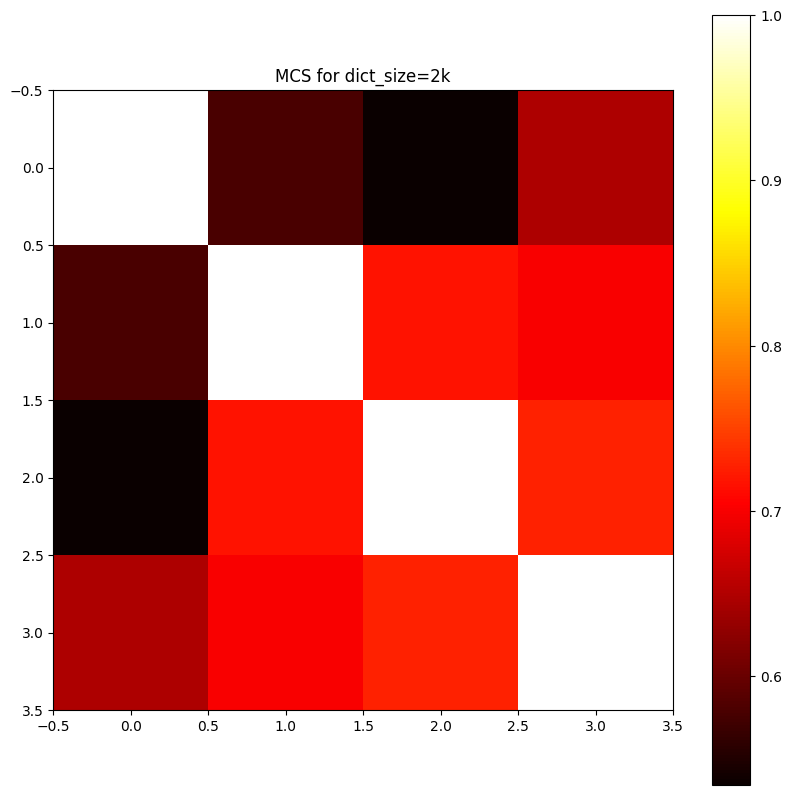

In [ ]:
# Plot the adjancy matrix
plt.figure(figsize=(10, 10))
plt.imshow(adjancy_matrix, cmap='hot', interpolation='nearest')
plt.title("MCS for dict_size=2k")
sparsities = [28,69,94,95,113,115,126,205,393]
# sparsities are x-axis
plt.xticks(range(len(sparsities)), sparsities)
plt.xlabel("Features/Tokens")
plt.colorbar()
plt.show()

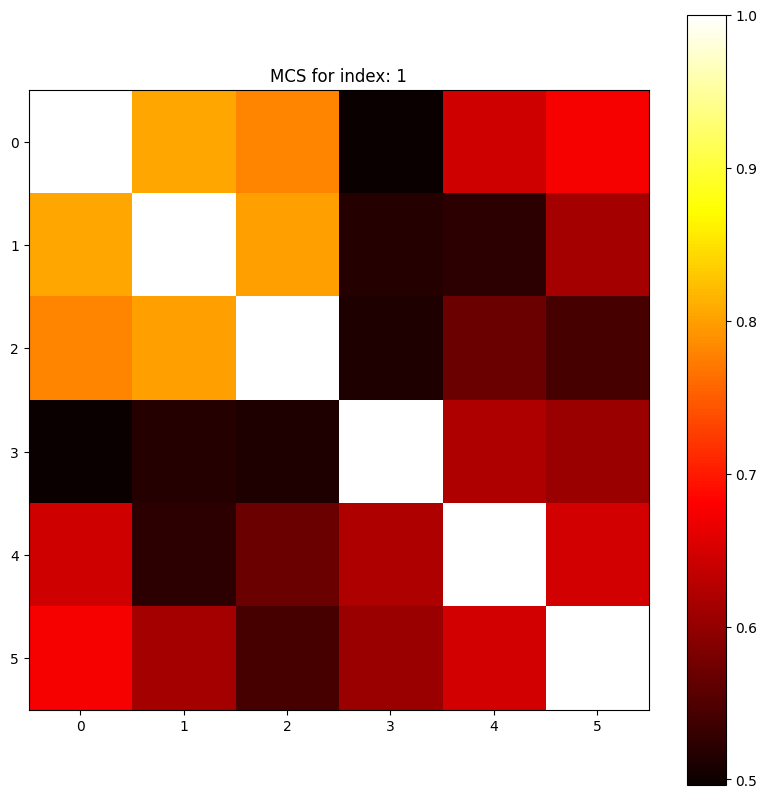

In [199]:
# Plot the adjancy matrix
plt.figure(figsize=(10, 10))
plt.imshow(adjancy_matrix, cmap='hot', interpolation='nearest')
plt.title("MCS for index: " + str(l1_index))
plt.colorbar()
plt.show()

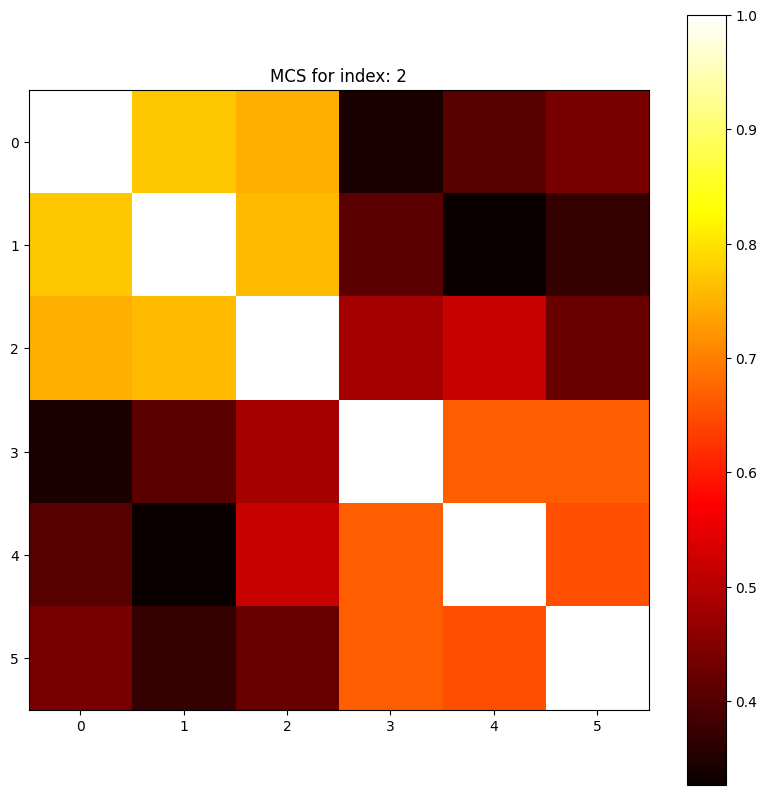

In [203]:
# Plot the adjancy matrix
plt.figure(figsize=(10, 10))
plt.imshow(adjancy_matrix, cmap='hot', interpolation='nearest')
plt.title("MCS for index: " + str(l1_index))
plt.colorbar()
plt.show()

In [192]:
max_cosine_similarities.mean()

0.4964340803012419

# MCS
Max cosine similarity between one dictionary & another one. If they learned the same feature, then they'll have high cosine similarity. 

If two dictionaries learned it, it's probably a real feature.

('# of features above 0.9:', 268)


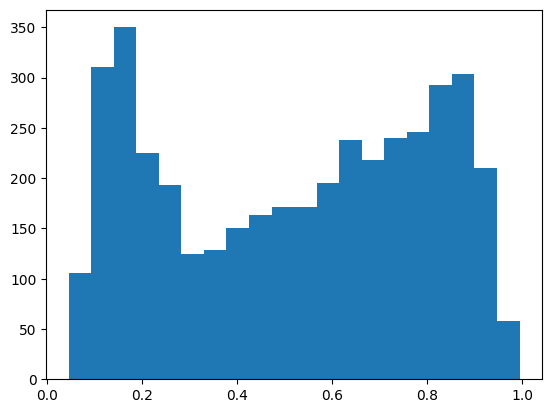

In [186]:
from scipy.optimize import linear_sum_assignment
import matplotlib.pyplot as plt
#Dictionary Comparison
smaller_dict_features, _ = smaller_dict.shape
larger_dict_features, _ = larger_dict.shape
larger_dict = larger_dict.to(device)
# Hungary algorithm
# Calculate all cosine similarities and store in a 2D array
cos_sims = np.zeros((smaller_dict_features, larger_dict_features))
for idx, vector in enumerate(smaller_dict):
    cos_sims[idx] = torch.nn.functional.cosine_similarity(vector.to(device), larger_dict, dim=1).cpu().numpy()
# Convert to a minimization problem
cos_sims = 1 - cos_sims
# Use the Hungarian algorithm to solve the assignment problem
row_ind, col_ind = linear_sum_assignment(cos_sims)
# Retrieve the max cosine similarities and corresponding indices
max_cosine_similarities = 1 - cos_sims[row_ind, col_ind]

# Get the indices of the max cosine similarities in descending order
max_indices = np.argsort(max_cosine_similarities)[::-1].copy()
print(("# of features above 0.9:", (max_cosine_similarities > .9).sum()))
# Plot histogram of max_cosine_similarities
plt.hist(max_cosine_similarities, bins=20)
plt.show()

# Model activations & Dictionary Activations

In [4]:
# Downnload dataset
from datasets import Dataset, load_dataset
dataset_name = "NeelNanda/pile-10k"
token_amount= 40
dataset = load_dataset(dataset_name, split="train").map(
    lambda x: model.tokenizer(x['text']),
    batched=True,
).filter(
    lambda x: len(x['input_ids']) > token_amount
).map(
    lambda x: {'input_ids': x['input_ids'][:token_amount]}
)

Found cached dataset parquet (/home/mchorse/.cache/huggingface/datasets/NeelNanda___parquet/NeelNanda--pile-10k-72f566e9f7c464ab/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)
Loading cached processed dataset at /home/mchorse/.cache/huggingface/datasets/NeelNanda___parquet/NeelNanda--pile-10k-72f566e9f7c464ab/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec/cache-936bbe7f6d7ada8a.arrow
Loading cached processed dataset at /home/mchorse/.cache/huggingface/datasets/NeelNanda___parquet/NeelNanda--pile-10k-72f566e9f7c464ab/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec/cache-ff63f286be92e51d.arrow
Loading cached processed dataset at /home/mchorse/.cache/huggingface/datasets/NeelNanda___parquet/NeelNanda--pile-10k-72f566e9f7c464ab/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec/cache-2658d87f3574d377.arrow


In [46]:
# Now we can use the model to get the activations
from torch.utils.data import DataLoader
from tqdm.auto import tqdm
from einops import rearrange
# neurons = model.W_in.shape[-1]
neurons = model.cfg.d_model
datapoints = dataset.num_rows
batch_size = 64
neuron_activations = torch.zeros((datapoints*token_amount, neurons))
dictionary_activations = torch.zeros((datapoints*token_amount, smaller_dict_features))
smaller_auto_encoder = smaller_auto_encoder.to(device)

with torch.no_grad(), dataset.formatted_as("pt"):
    dl = DataLoader(dataset["input_ids"], batch_size=batch_size)
    for i, batch in enumerate(tqdm(dl)):
        _, cache = model.run_with_cache(batch.to(device))
        batched_neuron_activations = rearrange(cache[cache_name], "b s n -> (b s) n" )
        neuron_activations[i*batch_size*token_amount:(i+1)*batch_size*token_amount,:] = batched_neuron_activations.cpu()
        reconstruction, batched_dictionary_activations = smaller_auto_encoder(batched_neuron_activations)
        dictionary_activations[i*batch_size*token_amount:(i+1)*batch_size*token_amount,:] = batched_dictionary_activations.cpu()

100%|██████████| 155/155 [00:07<00:00, 20.74it/s]


# Feature Activation Analysis

## Useful Functions

In [47]:
from circuitsvis.activations import text_neuron_activations
# Get the activations for the best dict features
def get_feature_datapoints(feature_index, dictionary_activations, dataset, k=10, setting="max"):
    best_feature_activations = dictionary_activations[:, feature_index]
    # Sort the features by activation, get the indices
    if setting=="max":
        found_indices = torch.argsort(best_feature_activations, descending=True)[:k]
    elif setting=="uniform":
        min_value = torch.min(best_feature_activations)
        max_value = torch.max(best_feature_activations)

        # Define the number of bins
        num_bins = k

        # Calculate the bin boundaries as linear interpolation between min and max
        bin_boundaries = torch.linspace(min_value, max_value, num_bins + 1)

        # Assign each activation to its respective bin
        bins = torch.bucketize(best_feature_activations, bin_boundaries)

        # Initialize a list to store the sampled indices
        sampled_indices = []

        # Sample from each bin
        for bin_idx in torch.unique(bins):
            # Get the indices corresponding to the current bin
            bin_indices = torch.nonzero(bins == bin_idx, as_tuple=False).squeeze(dim=1)
            
            # Randomly sample from the current bin
            sampled_indices.extend(np.random.choice(bin_indices, size=1, replace=False))

        # Convert the sampled indices to a PyTorch tensor & reverse order
        found_indices = torch.tensor(sampled_indices).long().flip(dims=[0])
    else: # random
        # get nonzero indices
        nonzero_indices = torch.nonzero(best_feature_activations)[:, 0]
        # shuffle
        shuffled_indices = nonzero_indices[torch.randperm(nonzero_indices.shape[0])]
        found_indices = shuffled_indices[:k]
    datapoint_indices =[np.unravel_index(i, (datapoints, token_amount)) for i in found_indices]
    text_list = []
    full_text = []
    token_list = []
    full_token_list = []
    for md, s_ind in datapoint_indices:
        md = int(md)
        s_ind = int(s_ind)
        full_tok = torch.tensor(dataset[md]["input_ids"])
        full_text.append(model.tokenizer.decode(full_tok))
        tok = dataset[md]["input_ids"][:s_ind+1]
        text = model.tokenizer.decode(tok)
        text_list.append(text)
        token_list.append(tok)
        full_token_list.append(full_tok)
    return text_list, full_text, token_list, full_token_list

def get_neuron_activation(token, feature, model, setting="dictionary_basis"):
    with torch.no_grad():
        _, cache = model.run_with_cache(token.to(model.cfg.device))
        neuron_act_batch = cache[cache_name]
        if setting=="dictionary_basis":
            _, act = smaller_auto_encoder(neuron_act_batch)
            return act[0, :, feature].tolist()
        else: # neuron/residual basis
            return neuron_act_batch[0, :, feature].tolist()

def ablate_text(text, feature, model, setting="plot"):
    if isinstance(text, str):
        text = [text]
    display_text_list = []
    activation_list = []
    for t in text:
        # Convert text into tokens
        if isinstance(t, str): # If the text is a list of tokens
            split_text = model.to_str_tokens(t, prepend_bos=False)
            tokens = model.to_tokens(t, prepend_bos=False)
        else: # t equals tokens
            tokens = t
            split_text = model.to_str_tokens(t, prepend_bos=False)
        seq_size = tokens.shape[1]
        if(seq_size == 1): # If the text is a single token, we can't ablate it
            continue
        original = get_neuron_activation(tokens, feature, model)[-1]
        changed_activations = torch.zeros(seq_size, device=device).cpu()
        for i in range(seq_size):
            # Remove the i'th token from the input
            ablated_tokens = torch.cat((tokens[:,:i], tokens[:,i+1:]), dim=1)
            changed_activations[i] += get_neuron_activation(ablated_tokens, feature, model)[-1]
        changed_activations -= original
        display_text_list += [x.replace('\n', '\\newline') for x in split_text] + ["\n"]
        activation_list += changed_activations.tolist() + [0.0]
    activation_list = torch.tensor(activation_list).reshape(-1,1,1)
    if setting == "plot":
        return text_neuron_activations(tokens=display_text_list, activations=activation_list)
    else:
        return display_text_list, activation_list
def visualize_text(text, feature, model, setting="dictionary_basis", max_activation = None):
    if isinstance(text, str):
        text = [text]
    if isinstance(feature, int):
        feature = [feature]
    display_text_list = []
    act_list = []
    for t in text:
        if isinstance(t, str): # If the text is a list of tokens
            split_text = model.to_str_tokens(t, prepend_bos=False)
            token = model.to_tokens(t, prepend_bos=False)
        else: # t are tokens
            token = t
            split_text = model.to_str_tokens(t, prepend_bos=False)
        for f in feature:
            display_text_list += [x.replace('\n', '\\newline') for x in split_text] + ["\n"]
            act_list += get_neuron_activation(token, f, model, setting) + [0.0]
    act_list = torch.tensor(act_list).reshape(-1,1,1)
    if(max_activation is not None):
        act_list = torch.clamp(act_list, max=max_activation)
    return text_neuron_activations(tokens=display_text_list, activations=act_list)
# Ablate the feature direction of the tokens
# token_list is a list of tokens, convert to tensor of shape (batch_size, seq_len)
from einops import rearrange
def ablate_feature_direction(tokens, feature, model, autoencoder):
    def mlp_ablation_hook(value, hook):
        # Rearrange to fit autoencoder
        int_val = rearrange(value, 'b s h -> (b s) h')

        # Run through the autoencoder
        _, act = autoencoder(int_val)
        feature_to_ablate = feature # TODO: bring this out of the function

        # Subtract value with feature direction*act_of_feature
        feature_direction = torch.outer(act[:, feature_to_ablate].squeeze(), autoencoder.decoder.weight[:, feature_to_ablate].squeeze())
        batch, seq_len, hidden_size = value.shape
        feature_direction = rearrange(feature_direction, '(b s) h -> b s h', b=batch, s=seq_len)
        value -= feature_direction
        return value

    return model.run_with_hooks(tokens, 
        fwd_hooks=[(
            cache_name, 
            mlp_ablation_hook
            )]
        )
def add_feature_direction(tokens, feature, model, autoencoder, scalar=1.0):
    def residual_add_hook(value, hook):
        feature_direction = autoencoder.decoder.weight[:, feature].squeeze()
        value += scalar*feature_direction
        return value

    return model.run_with_hooks(tokens, 
        fwd_hooks=[(
            cache_name,
            residual_add_hook
            )]
        )
def ablate_feature_direction_display(text, features=None, setting="true_tokens", verbose=False):

    if features==None:
        features = torch.tensor([best_feature])
    if isinstance(features, int):
        features = torch.tensor([features])
    if isinstance(features, list):
        features = torch.tensor(features)
    if isinstance(text, str):
        text = [text]
    text_list = []
    logit_list = []
    for t in text:
        tokens = model.to_tokens(t, prepend_bos=False)
        with torch.no_grad():
            original_logits = model(tokens).log_softmax(-1).cpu()
            ablated_logits = ablate_feature_direction(tokens, features, model, smaller_auto_encoder).log_softmax(-1).cpu()
        diff_logits = ablated_logits  - original_logits# ablated > original -> negative diff
        tokens = tokens.cpu()
        if setting == "true_tokens":
            split_text = model.to_str_tokens(t, prepend_bos=False)
            gather_tokens = rearrange(tokens[:,1:], "b s -> b s 1") # TODO: verify this is correct
            # Gather the logits for the true tokens
            diff = rearrange(diff_logits[:, :-1].gather(-1,gather_tokens), "b s n -> (b s n)")
        elif setting == "max":
            # Negate the diff_logits to see which tokens have the largest effect on the neuron
            val, ind = (-1*diff_logits).max(-1)
            diff = rearrange(val[:, :-1], "b s -> (b s)")
            diff*= -1 # Negate the values gathered
            split_text = model.to_str_tokens(ind, prepend_bos=False)
            gather_tokens = rearrange(ind[:,1:], "1 s -> 1 s 1")
        split_text = split_text[1:] # Remove the first token since we're not predicting it
        if(verbose):
            text_list += [x.replace('\n', '\\newline') for x in split_text] + ["\n"]
            text_list += [x.replace('\n', '\\newline') for x in split_text] + ["\n"]
            orig = rearrange(original_logits[:, :-1].gather(-1, gather_tokens), "b s n -> (b s n)")
            ablated = rearrange(ablated_logits[:, :-1].gather(-1, gather_tokens), "b s n -> (b s n)")
            logit_list += orig.tolist() + [0.0]
            logit_list += ablated.tolist() + [0.0]
        text_list += [x.replace('\n', '\\newline') for x in split_text] + ["\n"]
        logit_list += diff.tolist() + [0.0]
    logit_list = torch.tensor(logit_list).reshape(-1,1,1)
    if verbose:
        print(f"Max & Min logit-diff: {logit_list.max().item():.2f} & {logit_list.min().item():.2f}")
    return text_neuron_activations(tokens=text_list, activations=logit_list)
def generate_text(input_text, num_tokens, model, autoencoder, feature, temperature=0.7, setting="add", scalar=1.0):
    # Convert input text to tokens
    input_ids = model.tokenizer.encode(input_text, return_tensors='pt').to(device)

    for _ in range(num_tokens):
        # Generate logits
        with torch.no_grad():
            if(setting=="add"):
                logits = add_feature_direction(input_ids, feature, model, autoencoder, scalar=scalar)
            else:
                logits = model(input_ids)

        # Apply temperature
        logits = logits / temperature

        # Sample from the distribution
        probs = torch.nn.functional.softmax(logits[:, -1, :], dim=-1)
        predicted_token = torch.multinomial(probs, num_samples=1)

        # Append predicted token to input_ids
        input_ids = torch.cat((input_ids, predicted_token), dim=-1)

    # Decode the tokens to text
    output_text = model.tokenizer.decode(input_ids[0])

    return output_text

# Logit Lens
def logit_lens(model, best_feature, smaller_dict, layer):
    with torch.no_grad():
        # There are never-used tokens, which have high norm. We want to ignore these.
        bad_ind = (model.W_U.norm(dim=0) > 20)
        feature_direction = smaller_dict[best_feature].to(device)
        # feature_direction = torch.matmul(feature_direction, model.W_out[layer]) # if MLP
        logits = torch.matmul(feature_direction, model.W_U).cpu()
    # Don't include bad indices
    logits[bad_ind] = -1000
    topk_values, topk_indices = torch.topk(logits, 20)
    top_text = model.to_str_tokens(topk_indices)
    print(f"{top_text}")
    print(topk_values)


# Generate Text
You can use the functions below to find interesting features to then add here to "feature"

In [8]:
sentence = " for"
temp = 0.7
tokens_to_generate = 20
feature = 10 
scalar = 100.0
# Using the function:
print("Normal:\n" + generate_text(sentence, tokens_to_generate, model, smaller_auto_encoder, feature=feature, temperature=temp, scalar=scalar, setting="normal"))
print("Add:\n" + generate_text(sentence, tokens_to_generate, model, smaller_auto_encoder, feature=feature, temperature=temp, scalar=scalar, setting="add"))

Normal:
 for a certain place.

Lilmore

The Lilmore is a three-mile
Add:
 for,” LLP LLP LLP LLP LLP LLP Court,” LLPheets,” Court“ He LLP ruled His,”,’


# Feature Search
Type in a sentence & see which features activate 
Note: Some features may be outliers, which will typically show up as high activations for the first word & first period or \n (or high positive bias).

In [35]:
t = " I do like a"
split_text = model.to_str_tokens(t, prepend_bos=False)
token = model.to_tokens(t, prepend_bos=False)
_, cache = model.run_with_cache(token.to(model.cfg.device))
neuron_act_batch = cache[cache_name]
_, act = smaller_auto_encoder(neuron_act_batch)
v, i = act[0, -1, :].topk(10)

print("Activations:",[round(val,2) for val in v.tolist()])
print("Feature_ids", i.tolist())

Activations: [1.69, 1.45, 1.39, 1.21, 0.91, 0.54, 0.49, 0.46, 0.37, 0.28]
Feature_ids [1461, 1655, 389, 1309, 444, 82, 1300, 1206, 1901, 798]


# Feature Interp
Investigate the example sentences the activate this feature.

Max: show max activating (tokens,contexts)

Uniform: Show range of activations from each bin (e.g. sample an example from 1-2, 2-3, etc). 
[Note: if a feature is monosemantic, then the full range of activations should be that feature, not just max-activating ones]

Full_text: shows the full text example

Text_list: shows up to the most activating example (try w/ max activating on a couple of examples to see)

ablate_text: remove the context one token at a time, and show the decrease/increase in activation of that feature

ablate_feature_direction: removes feature direction from model's activation mid-inference, showing the logit diff in the output for every token.

logit_lens: show the logit lens for that feature. If matches ablate_feature_direction, then the computation path is through the residual stream, else, it's through future layers

In [183]:
# l1 = 8e-4, first 8 features don't make sense
# 1-3k mostly makes sense. Degrades after 3k (.6 MCS)
# 1505, Japanese words

# l1 = 4e-4. Loads of single letter features, unsure how legit they are
# 127 - induction thing
# 1002 - Japanese language, predicts common japanese endings & grammar (their comma char & quotations)
# 1012 ? maybe poly, maybe context neuron
# 1500: num after +/-
# 1501: food-related
# 1505 Poly
# 2506 Poly
# l1 = 2e-4. Definitely some real features, but many many polysemantic ones
N = 2506
best_feature = int(max_indices[N])
# best_feature = 1
print("bias:", smaller_auto_encoder.encoder_bias.detach().cpu().numpy()[best_feature])
print(f"Feature index: {best_feature}")
print(f"MCS: {max_cosine_similarities[best_feature]}")
text_list, full_text, token_list, full_token_list = get_feature_datapoints(best_feature, dictionary_activations, dataset, setting="uniform")
# text_list, full_text, token_list, full_token_list = get_feature_datapoints(best_feature, dictionary_activations, dataset, setting="max")
visualize_text(full_text, best_feature, model)

bias: -0.6367971
Feature index: 1659
MCS: 0.5792028903961182


In [184]:
ablate_text(text_list, best_feature, model)

In [165]:
ablate_feature_direction_display(full_text, best_feature)

In [166]:
logit_lens(model,best_feature, smaller_dict, layer)

[' dancing', ' ones', ' anyway', 'standing', 'pered', ' sex', 'inea', 'arte', 'anza', ' standing', ' advent', ' singing', ' kissing', 'enance', ' looming', ' temptation', ' eating', ' naked', 'aucoup', 'roph']
tensor([1.5851, 1.5664, 1.5380, 1.5162, 1.4991, 1.4883, 1.4554, 1.4353, 1.4333,
        1.4072, 1.3887, 1.3843, 1.3665, 1.3641, 1.3605, 1.3585, 1.3564, 1.3544,
        1.3537, 1.3528])


In [14]:
custom_text = [
    " Your text here",
]
visualize_text(custom_text, best_feature, model)

# Data Centric Viewpoint

In [19]:
# Go through datapoints & see if the features that activate on them make sense.
d_point = 0
# text = tokens_dataset[d_point]
data_ind, sequence_pos = np.unravel_index(d_point, (datapoints, token_amount))
feature_val, feature_ind = dictionary_activations[d_point].topk(10)
data_ind = int(data_ind)
sequence_pos = int(sequence_pos)
full_tok = torch.tensor(dataset[data_ind]["input_ids"])
full_text = []
full_text.append(model.tokenizer.decode(full_tok))
visualize_text(full_text, feature_ind, model)

# Check the neuron/residual basis
When we look at the weights of a feature, we are seeing the literal dimensions from the residual stream/neurons being read from the feature. 

Here I'm visualizing the weight values for the residual stream. If there are outliers, then it's mainly reading from that dimension.

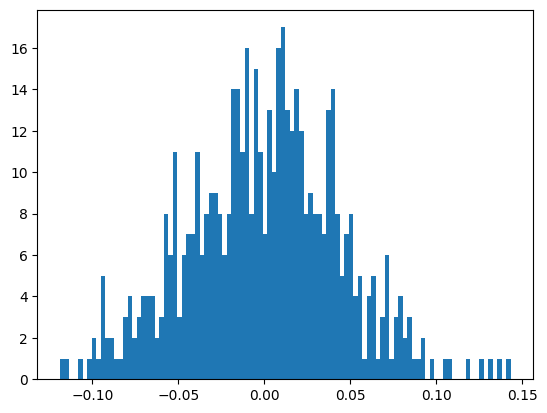

In [20]:
# Check features non-zero weights in decoder
# Plot a histogram of the weights
max_activation = dictionary_activations[:, best_feature].max()
weights = smaller_dict[best_feature]
plt.hist(weights, bins=100)
plt.show()

In [21]:
(weights*max_activation).topk(20), (weights*max_activation).topk(20, largest=False).values, (weights*max_activation > 0.2).sum()

(torch.return_types.topk(
 values=tensor([0.4587, 0.4407, 0.4183, 0.4015, 0.3814, 0.3496, 0.3330, 0.3156, 0.2968,
         0.2948, 0.2846, 0.2781, 0.2736, 0.2714, 0.2680, 0.2593, 0.2587, 0.2563,
         0.2554, 0.2505]),
 indices=tensor([478, 436,  98, 321,  87, 458, 230, 464, 129,  31, 137, 377, 263, 401,
         291,  92, 132,  56, 109, 246])),
 tensor([-0.3796, -0.3700, -0.3456, -0.3286, -0.3197, -0.3164, -0.3107, -0.3015,
         -0.3011, -0.3000, -0.2976, -0.2964, -0.2894, -0.2886, -0.2828, -0.2822,
         -0.2763, -0.2675, -0.2606, -0.2588]),
 tensor(39))

# Prepend/Append tokens
We can iterate over all tokens to check which ones activate a feature a lot to more rigorously test a hypothesis on what a feature means.

Note: I'm literately running the model through all 50k tokens prepended to the text here

In [22]:
def prepend_all_tokens_and_get_feature_activation(model, minimal_activating_example, feature, setting="prepend"):
    tokens = model.to_tokens(minimal_activating_example, prepend_bos=False)

    # Run through every number up to vocab size
    vocab_size = model.cfg.d_vocab
    batch_size = 256*2 # Define your desired batch size

    dollar_feature_activations = torch.zeros(vocab_size)
    for start in range(0, vocab_size, batch_size):
        end = min(start + batch_size, vocab_size)

        token_prep = torch.arange(start, end).to(device)
        token_prep = token_prep.unsqueeze(1)  # Add a dimension for concatenation

        # 1. Prepend to the tokens
        if setting == "prepend":
            tokens_catted = torch.cat((token_prep, tokens.repeat(end - start, 1)), dim=1).long()
        elif setting == "append":
            tokens_catted = torch.cat((tokens.repeat(end - start, 1), token_prep), dim=1).long()
        else:
            raise ValueError(f"Unknown setting: {setting}")

        # 2. Run through the model
        with torch.no_grad():
            _, cache = model.run_with_cache(tokens_catted.to(device))
            neuron_act_batch = cache[cache_name]
            _, act = smaller_auto_encoder(neuron_act_batch)

        # 3. Get the feature
        dollar_feature_activations[start:end] = act[:, -1, feature].cpu().squeeze()

    k = 20
    k_increasing_val, k_increasing_ind = dollar_feature_activations.topk(k)
    k_decreasing_val, k_decreasing_ind = dollar_feature_activations.topk(k, largest=False)
    if(setting == "prepend"):
        print(f"[token]{minimal_activating_example}")
    elif(setting == "append"):
        print(f"{minimal_activating_example}[token]")
    else:
        raise ValueError(f"Unknown setting: {setting}")
    # Print indices converted to tokens
    print(f"Top-{k} increasing: {model.to_str_tokens(k_increasing_ind)}")
    # Print values
    print(f"Top-{k} increasing: {[f'{val:.2f}' for val in k_increasing_val]}")
    print(f"Top-{k} decreasing: {model.to_str_tokens(k_decreasing_ind)}")
    print(f"Top-{k} decreasing: {[f'{val:.2f}' for val in k_decreasing_val]}")
    print(f"Number of 0 activations: {torch.sum(dollar_feature_activations == 0)}")
    if(setting == "prepend"):
        best_text = "".join(model.to_str_tokens(dollar_feature_activations.argmax()) + [minimal_activating_example])
    else:
        best_text = "".join([minimal_activating_example] + model.to_str_tokens(dollar_feature_activations.argmax()))
    return best_text

best_text = ""
for x in range(3):
    # best_text = prepend_all_tokens_and_get_feature_activation(model, best_text, best_feature, setting="prepend")
    best_text = prepend_all_tokens_and_get_feature_activation(model, best_text, best_feature, setting="append")
# prepend_all_tokens_and_get_feature_activation(model, " for all $", best_feature, setting="prepend")
# prepend_all_tokens_and_get_feature_activation(model, " tree", best_feature, setting="prepend")
# prepend_all_tokens_and_get_feature_activation(model, " tree", best_feature, setting="append")

[token]
Top-20 increasing: ['1', ')', '#', '/', '+', "'", '2', '<|padding|>', '*', '$', '.', ',', '&', '0', '"', '(', '<|endoftext|>', '!', '%', '-']
Top-20 increasing: ['0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00']
Top-20 decreasing: ['1', ')', '#', '/', '+', "'", '2', '<|padding|>', '*', '$', '.', ',', '&', '0', '"', '(', '<|endoftext|>', '!', '%', '-']
Top-20 decreasing: ['0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00']
Number of 0 activations: 50304
<|endoftext|>[token]
Top-20 increasing: [' a', '#', '1', ')', '/', "'", '2', '<|padding|>', '$', '*', '+', '.', '&', '0', '"', '(', ',', '<|endoftext|>', '!', '%']
Top-20 increasing: ['0.11', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00

In [23]:
best_text = ""
for x in range(3):
    best_text = prepend_all_tokens_and_get_feature_activation(model, best_text, best_feature, setting="prepend")

[token]
Top-20 increasing: ['1', ')', '#', '/', '+', "'", '2', '<|padding|>', '*', '$', '.', ',', '&', '0', '"', '(', '<|endoftext|>', '!', '%', '-']
Top-20 increasing: ['0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00']
Top-20 decreasing: ['1', ')', '#', '/', '+', "'", '2', '<|padding|>', '*', '$', '.', ',', '&', '0', '"', '(', '<|endoftext|>', '!', '%', '-']
Top-20 decreasing: ['0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00']
Number of 0 activations: 50304
[token]<|endoftext|>
Top-20 increasing: ['1', ')', '#', '/', '+', "'", '2', '<|padding|>', '*', '$', '.', ',', '&', '0', '"', '(', '<|endoftext|>', '!', '%', '-']
Top-20 increasing: ['0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00'

In [24]:
prepend_all_tokens_and_get_feature_activation(model, " for all $", best_feature, setting="prepend")
# prepend_all_tokens_and_get_feature_activation(model, "The", best_feature, setting="append")
# prepend_all_tokens_and_get_feature_activation(model, " tree", best_feature, setting="append")

[token] for all $
Top-20 increasing: ['1', ')', '#', '/', '+', "'", '2', '<|padding|>', '*', '$', '.', ',', '&', '0', '"', '(', '<|endoftext|>', '!', '%', '-']
Top-20 increasing: ['0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00']
Top-20 decreasing: ['1', ')', '#', '/', '+', "'", '2', '<|padding|>', '*', '$', '.', ',', '&', '0', '"', '(', '<|endoftext|>', '!', '%', '-']
Top-20 decreasing: ['0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00']
Number of 0 activations: 50304


'<|endoftext|> for all $'